<a href="https://colab.research.google.com/github/brunotagoncalves/publicdataml/blob/main/Modelagem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 3.	Modelagem

In [1]:
!pip install catboost

     |████████████████████████████████| 65.7MB 53kB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np 

Mounted at /content/drive


In [3]:
from catboost import Pool, CatBoostRegressor

In [4]:
pd_df = pd.read_csv('drive/MyDrive/publicdataml/sample_data_featured_v1.csv',dtype='object',index_col=0)
cat_cols = pd_df.columns[pd_df.columns.str.contains('Descrição|dig')].tolist()
int_cols = pd_df.columns[pd_df.columns.str.contains('idade|pop_')].tolist()
target_cols = pd_df.columns[pd_df.columns.str.contains('salário|valor')].tolist()
key_cols = pd_df.columns[pd_df.columns.str.contains('faixapnad')].tolist()

In [5]:
for i in int_cols+target_cols:
  pd_df.loc[:,i] = pd_df.loc[:,i].astype('float')


In [6]:
pd_df = pd_df.loc[~pd_df.isnull().any(axis=1),:]

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(pd_df.loc[:,cat_cols+int_cols+key_cols], pd_df.loc[:,'salário'],random_state=123,test_size=.25)

In [8]:
idx_cat = [X_train.columns.get_loc(i) for i in cat_cols]

In [9]:
# initialize Pool
train_pool = Pool(X_train[cat_cols+int_cols], 
                  y_train, 
                  cat_features=idx_cat)

test_pool = Pool(X_test[cat_cols+int_cols], 
                 y_test, 
                 cat_features=idx_cat) 


In [10]:
# specify the training parameters 
model1 = CatBoostRegressor(loss_function='MAE',eval_metric='MAPE',iterations=3000)
#train the model
model1.fit(train_pool,eval_set=test_pool)
model1.save_model('drive/MyDrive/publicdataml/ensemble_model_75.sav')

0:	learn: 0.5370977	test: 0.5420406	best: 0.5420406 (0)	total: 1.03s	remaining: 51m 45s
1:	learn: 0.5275428	test: 0.5322607	best: 0.5322607 (1)	total: 1.88s	remaining: 46m 54s
2:	learn: 0.5183038	test: 0.5228221	best: 0.5228221 (2)	total: 2.83s	remaining: 47m 3s
3:	learn: 0.5096363	test: 0.5139409	best: 0.5139409 (3)	total: 3.65s	remaining: 45m 36s
4:	learn: 0.5010940	test: 0.5052091	best: 0.5052091 (4)	total: 4.49s	remaining: 44m 49s
5:	learn: 0.4933029	test: 0.4972073	best: 0.4972073 (5)	total: 5.33s	remaining: 44m 19s
6:	learn: 0.4855714	test: 0.4892602	best: 0.4892602 (6)	total: 6.18s	remaining: 44m 4s
7:	learn: 0.4783716	test: 0.4818397	best: 0.4818397 (7)	total: 7.01s	remaining: 43m 43s
8:	learn: 0.4714280	test: 0.4746887	best: 0.4746887 (8)	total: 7.86s	remaining: 43m 32s
9:	learn: 0.4643485	test: 0.4674674	best: 0.4674674 (9)	total: 8.94s	remaining: 44m 32s
10:	learn: 0.4580783	test: 0.4609946	best: 0.4609946 (10)	total: 9.79s	remaining: 44m 18s
11:	learn: 0.4521764	test: 0.454

In [11]:
# make the prediction using the resulting model
model1 = CatBoostRegressor()
model1.load_model('drive/MyDrive/publicdataml/ensemble_model_75.sav')



In [11]:
preds = model1.predict(test_pool)
#print(preds)

In [12]:
pd_df_test = pd.concat([X_test,y_test],axis=1)

pd_df_test.loc[:,'preds'] = preds

In [13]:
import sklearn.metrics as metrics
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    mean_absolute_percentage_error=np.mean(np.abs(y_true-y_pred)/y_true)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MAPE: ', round(mean_absolute_percentage_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [14]:
regression_results(y_test,preds)

explained_variance:  0.4688
mean_squared_log_error:  0.155
r2:  0.463
MAE:  633.3031
MAPE:  0.2754
MSE:  4078608.3396
RMSE:  2019.5565


In [15]:
pd_df_test.loc[:,'AE'] = np.abs(pd_df_test.loc[:,'salário'] - pd_df_test.loc[:,'preds'])
pd_df_test.loc[:,'APE'] = pd_df_test.loc[:,'AE']/pd_df_test.loc[:,'salário']

In [16]:
pd_df_test.loc[:,['salário','preds']].corr('pearson')**2

,salário,preds
salário,1.00000,0.48431
preds,0.48431,1.00000


In [17]:
pd_df_test.groupby('faixapnad')['APE'].describe()

,count,mean,std,min,25%,50%,75%,max
faixapnad,,,,,,,,
1º Quintil PNAD,12678.0,0.482780,0.833317,0.000004,0.035628,0.122354,0.736241,17.346139
2º Quintil PNAD,12295.0,0.189937,0.419642,0.000003,0.016700,0.056153,0.208745,7.422713
3º Quintil PNAD,12461.0,0.159168,0.281458,0.000005,0.039601,0.087915,0.175868,5.047217
4º Quintil PNAD,12627.0,0.222545,0.309344,0.000049,0.059138,0.141948,0.275406,4.564064
5º Quintil PNAD,12512.0,0.318467,0.241230,0.000009,0.127568,0.280030,0.461235,2.359266


In [18]:
pd_df_test.groupby('faixapnad')['AE'].describe()

,count,mean,std,min,25%,50%,75%,max
faixapnad,,,,,,,,
1º Quintil PNAD,12678.0,254.057604,427.207175,0.001892,19.037641,66.772861,409.822525,10407.683659
2º Quintil PNAD,12295.0,171.494777,365.919241,0.003278,17.104410,55.647996,192.518175,5901.748004
3º Quintil PNAD,12461.0,203.043639,359.777451,0.006716,48.952833,109.889616,227.032308,5952.326357
4º Quintil PNAD,12627.0,424.116867,593.098231,0.073862,104.997217,257.721191,518.526362,8334.814371
5º Quintil PNAD,12512.0,2110.993589,3850.315852,0.035512,501.969948,1127.227178,2199.353594,48291.209622


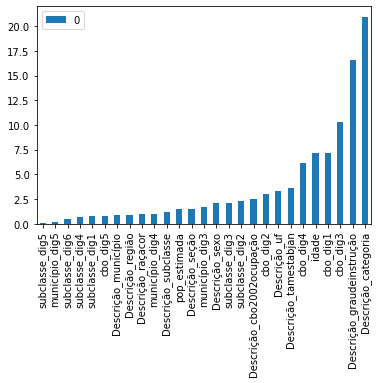

In [19]:
pd.DataFrame(model1.feature_importances_,index=cat_cols+int_cols).sort_values(0).plot.bar()

In [21]:
from sklearn.preprocessing import OneHotEncoder


In [22]:
OHE = OneHotEncoder(handle_unknown='ignore')

In [23]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

In [24]:
ct  = ColumnTransformer([('pp',Pipeline([
        ("OHE", OHE),('imp',SimpleImputer(strategy='most_frequent'))]),cat_cols),('imp',SimpleImputer(strategy='most_frequent'),int_cols)])

In [25]:
X_train_catcols = ct.fit_transform(X_train)
X_test_catcols = ct.transform(X_test)

In [26]:
from sklearn.neural_network import MLPRegressor

regr = MLPRegressor(random_state=1,solver='adam', verbose=True).fit(X_train_catcols, y_train)


Iteration 1, loss = 8072213.90598921
Iteration 2, loss = 5324559.91893640
Iteration 3, loss = 5691352.89652525
Iteration 4, loss = 5334503.46446272
Iteration 5, loss = 4876539.82991015
Iteration 6, loss = 4819139.07026740
Iteration 7, loss = 4908847.23814174
Iteration 8, loss = 4445464.86647503
Iteration 9, loss = 4668006.77918713
Iteration 10, loss = 4422385.53690315
Iteration 11, loss = 4552078.29982668
Iteration 12, loss = 4411094.62581673
Iteration 13, loss = 4371358.37542540
Iteration 14, loss = 4316227.69386342
Iteration 15, loss = 4276542.59244216
Iteration 16, loss = 4231691.90280425
Iteration 17, loss = 4158475.80482752
Iteration 18, loss = 4199258.80611854
Iteration 19, loss = 4097917.17333623
Iteration 20, loss = 4082520.16105967
Iteration 21, loss = 3995716.57134624
Iteration 22, loss = 4029342.98686289
Iteration 23, loss = 4001948.53989822
Iteration 24, loss = 3976046.51883899
Iteration 25, loss = 4090993.43409333
Iteration 26, loss = 3900171.57405670
Iteration 27, loss = 

In [27]:

from joblib import dump, load
dump(regr,'drive/MyDrive/publicdataml/mlp_model.joblib')
regr = load('drive/MyDrive/publicdataml/mlp_model.joblib')



In [28]:
preds = regr.predict(X_test_catcols)

In [32]:
pd_df_test.loc[:,'preds_mlp'] = preds
pd_df_test.loc[:,'preds_mlp'] = pd_df_test.loc[:,'preds_mlp'].apply(lambda x : x if x>400 else 400)

In [30]:
pd_df_test.loc[:,['salário','preds','preds_mlp']].corr()

,salário,preds,preds_mlp
salário,1.000000,0.695924,0.327956
preds,0.695924,1.000000,0.456564
preds_mlp,0.327956,0.456564,1.000000


In [33]:
regression_results(y_test,pd_df_test.loc[:,'preds_mlp'])

explained_variance:  0.1075
mean_squared_log_error:  0.495
r2:  0.0876
MAE:  1149.9917
MAPE:  0.6167
MSE:  6930403.0061
RMSE:  2632.5659


In [34]:
pd_df_test.loc[:,'AE_MLP'] = np.abs(pd_df_test.loc[:,'salário'] - pd_df_test.loc[:,'preds_mlp'])
pd_df_test.loc[:,'APE_MLP'] = pd_df_test.loc[:,'AE_MLP']/pd_df_test.loc[:,'salário']

In [35]:
pd_df_test.groupby('faixapnad')['APE_MLP'].describe()

,count,mean,std,min,25%,50%,75%,max
faixapnad,,,,,,,,
1º Quintil PNAD,12678.0,1.095855,1.346707,0.000000,0.204584,0.522833,1.509412,10.945417
2º Quintil PNAD,12295.0,0.653674,0.710049,0.000011,0.184114,0.398247,0.755300,4.954649
3º Quintil PNAD,12461.0,0.496954,0.437909,0.000109,0.188495,0.363449,0.619048,3.021970
4º Quintil PNAD,12627.0,0.368855,0.268355,0.000046,0.151027,0.316353,0.532942,1.579190
5º Quintil PNAD,12512.0,0.464420,0.261495,0.000019,0.237834,0.476970,0.689285,0.991474


In [36]:
pd_df_test.groupby('faixapnad')['AE_MLP'].describe()

,count,mean,std,min,25%,50%,75%,max
faixapnad,,,,,,,,
1º Quintil PNAD,12678.0,585.661338,707.419731,0.000000,112.120769,274.045741,808.987441,5199.072907
2º Quintil PNAD,12295.0,622.564848,642.506612,0.010956,178.270733,388.404688,721.842512,3865.369557
3º Quintil PNAD,12461.0,626.647707,547.364017,0.125928,233.769012,459.881787,778.780600,3946.783398
4º Quintil PNAD,12627.0,672.720853,470.612071,0.072802,278.489415,593.911113,1003.151040,2695.665337
5º Quintil PNAD,12512.0,3242.956768,4597.107965,0.056338,828.690482,1862.960563,3968.770483,47784.659183


In [46]:
pd_df_test.to_csv('drive/MyDrive/publicdataml/test_results.csv')

|Exemplos:| Sr. 98 | Monica | Ana |
|---|---|---|---|
|**Idade:**| 26  | 54  | 45  |
|**Munícipio:**|  Porto Alegre | São Paulo  | Fortaleza  |
|**Profissão:**| Humorista / Radialista  | Enfermeira | Diretora Comercial  |
|**Porte da Empresa:**| Mais de 1000 colaboradores  | Mais de 1000 colaboradores  | Entre 20 e 50 Colaboradores |
|**Grau de Instrução** | Ensino Médio Completo | Ensino Superior Completo | Pós-Graduação Completa



In [37]:
(model1.predict([
               'Sul'              
,'Rio Grande do Sul'
,'Rs-Porto Alegre'
,'Informação e Comunicação '
,'Atividades de Rádio'
,'Empregado - Geral, inclusive o empregado público da administração direta ou indireta contratado pela CLT'
,'Comentarista de Radio e Televisao'
,'Médio Completo'
,'Homem'
,'Preta'
,'1000 ou mais vínculos'
,'6'
,'60'
,'601'
,'6010'
,'60101'
,'601010'
,'2'
,'26'
,'261'
,'2617'
,'26171'
,'431'
,'4314'
,'43149'
,26
,1488252.0
])*3).round(-1)

6680.0

In [38]:
(model1.predict(['Sudeste'
,'São Paulo'
,'Sp-Sao Paulo'
,'Saúde Humana e Serviços Sociais'
,'Atividades de Atendimento Hospitalar, Exceto Pronto-Socorro e Unidades para Atendimento a Urgências'
,'Empregado - Geral, inclusive o empregado público da administração direta ou indireta contratado pela CLT'
,'Enfermeiro de Terapia Intensiva'
,'Superior Completo'
,'Mulher'
,'Preta'
,'1000 ou mais vínculos'
,'8'
,'86'
,'861'
,'8610'
,'86101'
,'861010'
,'2'
,'22'
,'223'
,'2235'
,'22352'
,'355'
,'3550'
,'35503'
,54
,12325200
])).round(-1)

5260.0

In [39]:
(model1.predict([ 'Nordeste'
,'Ceará'
,'Ce-Fortaleza'
,'Comércio, Reparação de Veículos Automotores e Motocicletas'
,'Comércio Varejista de Móveis'
,'Empregado - Geral, inclusive o empregado público da administração direta ou indireta contratado pela CLT'
,'Diretor Comercial'
,'Pós-Graduação completa'
,'Mulher'
,'Parda'
,'De 20 a 49 vínculos'
,'4'
,'47'
,'475'
,'4754'
,'47547'
,'475470'
,'1'
,'12'
,'123'
,'1233'
,'12330'
,'230'
,'2304'
,'23044'
,45
,2686610

])*2).round(-1)

12910.0

In [40]:
pd_df.loc[:,'preds'] = model1.predict(pd_df.loc[:,cat_cols+int_cols])

In [41]:
pd_df.sort_values('preds',ascending=False).head(20)

,Descrição_região,Descrição_uf,Descrição_município,Descrição_seção,Descrição_subclasse,Descrição_categoria,Descrição_cbo2002ocupação,Descrição_graudeinstrução,Descrição_sexo,Descrição_raçacor,Descrição_tamestabjan,subclasse_dig1,subclasse_dig2,subclasse_dig3,subclasse_dig4,subclasse_dig5,subclasse_dig6,cbo_dig1,cbo_dig2,cbo_dig3,cbo_dig4,cbo_dig5,município_dig3,município_dig4,município_dig5,idade,pop_estimada,faixapnad,salário,valorhora,preds
16383,Sudeste,São Paulo,Sp-Sao Paulo,"Atividades Financeiras, de Seguros e Serviços ...","Bancos Múltiplos, com Carteira Comercial","Empregado - Geral, inclusive o empregado públi...",Diretor Administrativo e Financeiro,Mestrado,Homem,Branca,1000 ou mais vínculos,6,64,642,6422,64221,642210,1,12,123,1231,12311,355,3550,35503,50.0,12325232.0,5º Quintil PNAD,40646.18,1016.154500,17306.630249
43802,Sudeste,Rio de Janeiro,Rj-Rio de Janeiro,"Atividades Financeiras, de Seguros e Serviços ...",Planos de Saúde,"Empregado - Geral, inclusive o empregado públi...",Diretor de Servicos de Saude,Pós-Graduação completa,Homem,Branca,De 500 a 999 vínculos,6,65,655,6550,65502,655020,1,13,131,1312,13120,330,3304,33045,65.0,6747815.0,5º Quintil PNAD,31404.00,897.257143,16365.099266
3596,Sudeste,São Paulo,Sp-Sao Paulo,"Atividades Financeiras, de Seguros e Serviços ...",Seguros de Vida,"Empregado - Geral, inclusive o empregado públi...",Diretor de Produtos Bancarios,Pós-Graduação completa,Homem,Amarela,De 100 a 249 vínculos,6,65,651,6511,65111,651110,1,12,122,1227,12271,355,3550,35503,46.0,12325232.0,5º Quintil PNAD,25000.00,568.181818,15815.841327
7647,Sudeste,São Paulo,Sp-Sao Paulo,"Atividades Financeiras, de Seguros e Serviços ...","Bancos Múltiplos, sem Carteira Comercial","Empregado - Geral, inclusive o empregado públi...",Diretor de Riscos de Mercado,Pós-Graduação completa,Homem,Branca,De 500 a 999 vínculos,6,64,643,6431,64310,643100,1,12,122,1227,12275,355,3550,35503,40.0,12325232.0,5º Quintil PNAD,42651.46,969.351364,15680.682454
1511,Sudeste,São Paulo,Sp-Sao Paulo,Indústrias de Transformação,Fabricação de Aditivos de Uso Industrial,"Empregado - Geral, inclusive o empregado públi...",Gerente de Vendas,Mestrado,Homem,Branca,De 100 a 249 vínculos,2,20,209,2093,20932,209320,1,14,142,1423,14232,355,3550,35503,56.0,12325232.0,5º Quintil PNAD,11063.84,251.450909,15609.215938
10806,Sudeste,São Paulo,Sp-Sao Paulo,Outras Atividades de Serviços,Atividades de Organizações Associativas Patron...,"Empregado - Geral, inclusive o empregado públi...",Diretor Administrativo,Mestrado,Homem,Branca,De 20 a 49 vínculos,9,94,941,9411,94111,941110,1,12,123,1231,12310,355,3550,35503,63.0,12325232.0,5º Quintil PNAD,34411.00,860.275000,15431.129972
35329,Sudeste,São Paulo,Sp-Sorocaba,Indústrias de Transformação,Fabricação de Baterias e Acumuladores para Veí...,"Empregado - Geral, inclusive o empregado públi...",Gerente de Projetos e Servicos de Manutencao,Pós-Graduação completa,Homem,Branca,1000 ou mais vínculos,2,27,272,2722,27228,272280,1,14,142,1427,14270,355,3552,35522,57.0,687357.0,5º Quintil PNAD,12285.21,279.209318,15096.816898
5462,Sudeste,São Paulo,Sp-Sao Paulo,"Atividades Financeiras, de Seguros e Serviços ...",Planos de Saúde,"Empregado - Geral, inclusive o empregado públi...",Diretor de Recursos Humanos,Pós-Graduação completa,Mulher,Branca,De 50 a 99 vínculos,6,65,655,6550,65502,655020,1,12,123,1232,12320,355,3550,35503,42.0,12325232.0,5º Quintil PNAD,43000.00,1075.000000,15088.544984
16562,Sudeste,São Paulo,Sp-Sao Paulo,Informação e Comunicação,Desenvolvimento e Licenciamento de Programas d...,"Empregado - Geral, inclusive o empregado públi...",Gerente de Pesquisa e Desenvolvimento (P&D),Pós-Graduação completa,Homem,Branca,1000 ou mais vínculos,6,62,620,6203,62031,620310,1,14,142,1426,14260,355,3550,35503,54.0,12325232.0,5º Quintil PNAD,18500.00,420.454545,14979.245898
16382,Sudeste,São Paulo,Sp-Sao Paulo,"Atividades Profissionais, Científicas e Técnicas",Atividades de Consultoria em Gestão Empresaria...,"Empregado 

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


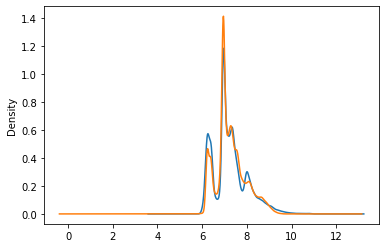

In [42]:
import numpy as np 
np.log1p(pd_df.loc[:,'salário']).plot.density()
np.log1p(pd_df.loc[:,'preds']).plot.density()
